In [1]:
import scipy.linalg as la
import os,sys,inspect

from tqdm import tqdm
import time
%pylab inline

from IPython import display


Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:


#Defining time scales
total_time = 100
steps =80000

state_transfer = True
RWA = True
RFT = True

#Defining H0





qubit_state_num = 2

fq= 4.6/(2*np.pi)
kappa = 0.05
gamma = 0.001
#kappa = 0
#gamma = 0
g = 0.05

mode_state_num = 25
#g = 2.*np.pi*0.1 #GHz
fc = 5.0/(2*np.pi) #GHz
state_num = qubit_state_num * mode_state_num
if RFT:
    fq = fq-fc
    fc = 0
    
wc = 2*np.pi*fc
wa = 2*np.pi*fq


alpha = 0.224574
ens = np.array([ 2*np.pi*ii*(fq - 0.5*(ii-1)*alpha) for ii in np.arange(qubit_state_num)])
H0q = np.kron(np.identity(mode_state_num),np.diag(ens))

a   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),1),np.identity(qubit_state_num))
adag   = np.kron(np.diag(np.sqrt(np.arange(1,mode_state_num)),-1),np.identity(qubit_state_num))
sm = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),1))
smdag = np.kron(np.identity(mode_state_num),np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))

print a
print sm
if RWA:
     H0 = wc * np.dot(adag,a) + H0q + g * (np.dot(adag,sm) + np.dot(a,smdag))
else:
     H0 = wc * np.dot(adag,a) + H0q +  g * np.dot((adag + a),(sm + smdag))
#Defining Forbidden sates


#Defining Concerned states (starting states)
psi0=[0,1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,2]
states_draw_names = ['g0','e0','g1']



#Defining U (Target)
if state_transfer:
    U =[]
    U1 = np.zeros(state_num,dtype=complex)
    U1[1]=1
    U1[0]=0
    U.append(U1)
    U2 = np.zeros(state_num,dtype=complex)
    U2[0]=1
    U.append(U2)
    
else:
    Ut_c = la.expm((0-1j)*total_time*H0)
    Ct_c = Ut_c.copy()
    Ct_c[1,0] = 1
    Ct_c[0,1] = 1
    Ct_c[0,0] = 0
    Ct_c[1,1] = 0
    U = Ct_c

print np.shape(U)
#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
U0= q_identity

#Defining control Hs
IX = a + adag
IY = (0+1j)* (a-adag)
Hops = [IX]
ops_max_amp = [0.1]
Hnames =['HI']

#Defining convergence parameters
max_iterations = 5000
decay = max_iterations/2
convergence = {'rate':0.005, 'update_step':10, 'max_iterations':max_iterations,\
               'conv_target':1e-6,'learning_rate_decay':decay}
reg_coeffs = {'envelope' : 0,  'dwdt':0,'d2wdt2':0}
#, 'forbidden':100 , 'states_forbidden_list': [3]
#reg_coeffs = { 'speed_up':100}
#reg_coeffs = {'envelope' : 0,  'dwdt':0,'d2wdt2':0}
#multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              #'f':freq_ge, 'es':w_c, 'g1':qm_g1, 'D':D, 'Interpolation':True, 'Modulation':True}

    #Defining initial pulses

print len(U)
print H0
print IX

[[ 0.          0.          1.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ...,  0.          0.          4.89897949]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.         ...,  0.          0.          0.        ]]
[[ 0.  1.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  1.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
(2, 50)
2
[[ 0.          0.          0.         ...,  0.          0.          0.        ]
 [ 0.         -0.4         0.05       ...,  0.          0.          0.        ]
 [ 0.          0.05        0.         ...,  0.          0.          0.        ]
 ..., 
 [ 0.          0.          0.         ..., -0.4        

In [4]:

c_ops=[]
c_ops.append(sm)
c_ops.append(a)
#c_ops.append(ef)

#print c_ops
print gamma


0.001


In [5]:
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Filter requirements.
order = 6
fs = 30.0       # sample rate, Hz
cutoff = 5

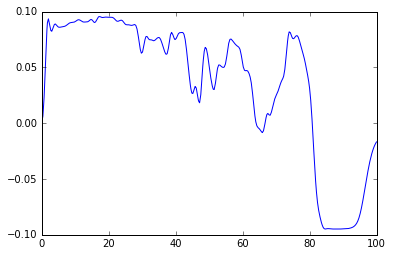

In [6]:
import h5py
u0=[]
with h5py.File('/home/mohamed/Data/00475_JC.h5','r') as hf:
    intr = 0.91*np.array(hf.get('uks'))[-1]
    u0.append(np.interp(np.linspace(0,total_time, steps),np.linspace(0,total_time, len(intr[0])),intr[0]))

#u0 = None
#u0 = []

u0=[]
with h5py.File('/home/nelson/Simulations/Mohamed/00072_JC.h5','r') as hf:
    intr = 0.95*butter_lowpass_filter(np.array(hf.get('uks'))[-1],cutoff,fs)
    u0.append(np.interp(np.linspace(0,total_time, steps),np.linspace(0,total_time, len(intr[0])),intr[0]))

signal = 0.07*np.tanh(np.linspace(0,total_time, steps)/10)
#signal = 0.095*np.cos(np.linspace(0,total_time, steps)/1.5)

#u0.append(signal)
#u0.append(signal)
#u0.append(2*np.ones(steps))

#u0 = None
plot (np.linspace(0,total_time, steps), u0[0])
#u0 = None
#u0 = []
#u0.append(np.clip(0.02*np.random.normal(size= steps),-0.1,0.1))
#plot(np.linspace(0,total_time, steps),u0[0])

In [38]:
def normalize(psi):
    norm = np.dot(np.conjugate(np.transpose(psi)),psi)
    return psi/np.sqrt(norm)

state = psi0[0]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1

psis = []
for ii in range (9):
    p = normalize(np.random.rand(state_num))
    psis.append(p)
psis = np.transpose(psis)

cdag = np.conjugate(np.transpose(c_ops[0]))
e0 = np.diag(np.dot(np.conjugate(np.transpose(psis)),np.dot(c_ops[0] + cdag,psis)))
cdag = np.conjugate(np.transpose(c_ops[1]))
e1 = np.diag(np.dot(np.conjugate(np.transpose(psis)),np.dot(c_ops[1] + cdag,psis)))

print e0
print e1
print np.shape(psis[:,0])
cdag = np.conjugate(np.transpose(c_ops[0]))
e0 = np.diag(np.dot(np.conjugate(np.transpose(np.reshape(psis[:,0],[state_num,1]))),np.dot(c_ops[0] + cdag,np.reshape(psis[:,0],[state_num,1]))))
print e0

print np.shape(e1*psis),np.shape(psis)

e1 = np.reshape(e1,[1,len(e1)])
print np.shape(e1)
#print (np.multiply(e1,psis))[:,0]

print np.shape(np.multiply(e1,psis))
#print e1
#print e1[:,0]*psis[:,0]
print np.multiply(e1,e1)
print e1
print np.shape(e1)

print np.shape(np.sum(np.multiply(np.conjugate(psis),psis),axis=0))
print 1/(np.sum(np.multiply(np.conjugate(psis),psis),axis=0))

[ 0.71908774  0.69091286  0.80842261  0.69516479  0.83142879  0.74285803
  0.80443548  0.77664773  0.7545038 ]
[ 4.16280462  4.49235154  4.28151147  4.59455558  5.10786462  5.14163686
  5.39989253  4.98914856  5.2232839 ]
(50,)
[ 0.71908774]
(50, 9) (50, 9)
(1, 9)
(50, 9)
[[ 17.32894229  20.18122234  18.33134047  21.10994102  26.090281
   26.43642961  29.15883933  24.89160337  27.28269469]]
[[ 4.16280462  4.49235154  4.28151147  4.59455558  5.10786462  5.14163686
   5.39989253  4.98914856  5.2232839 ]]
(1, 9)
(9,)
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [7]:
#Euler multiple

state = psi0[0]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1

print initial_vector_c

dt = float(total_time)/steps

print dt
def trajectories(psi):
    cdag0 = np.conjugate(np.transpose(c_ops[0]))
    e0 = np.diag(np.dot(np.conjugate(np.transpose(psi)),np.dot(c_ops[0] + cdag0,psi)))
    cdag1 = np.conjugate(np.transpose(c_ops[1]))
    e1 = np.diag(np.dot(np.conjugate(np.transpose(psi)),np.dot(c_ops[1] + cdag1,psi)))
    e0 = np.reshape(e0,[1,len(e0)])
    e1 = np.reshape(e1,[1,len(e1)])
    cdagc0 = np.dot(cdag0,c_ops[0])
    cdagc1 = np.dot(cdag1,c_ops[1])
   

    def get_drift(step):
        d = H0 
        d = d+ u0[0][step] *Hops[0]
        return d

   

    def normalize(psi):
        norms = np.reshape(1/np.sqrt(np.sum(np.multiply(np.conjugate(psi),psi),axis=0)),[1,len(e0[0])])
        
        return np.multiply(norms,psi)

    
    W1s = []
    W2s = []
    psis = []
    e1s = []
    psis.append(psi)
    
    for step in tqdm(range(steps)):
        
        drift = get_drift(step) #fine
        D1 = (0-1j)*drift - 0.5*gamma*cdagc0 - 0.5*kappa*cdagc1
        apsi0 = np.dot(c_ops[0],psi)
        apsi1 = np.dot(c_ops[1],psi)
        
        e0 = np.diag(np.dot(np.conjugate(np.transpose(psi)),np.dot(c_ops[0] + cdag0,psi)))
        e1 = np.diag(np.dot(np.conjugate(np.transpose(psi)),np.dot(c_ops[1] + cdag1,psi)))
        e1s.append(e1)
        e0 = np.reshape(e0,[1,len(e0)])
        e1 = np.reshape(e1,[1,len(e1)])
        
        
        D1psi = np.dot(D1,psi) + 0.5*gamma*np.multiply(e0,apsi0)+ 0.5*kappa*np.multiply(e1,apsi1) - 0.25*0.5*gamma*np.multiply(np.multiply(e0,e0),psi)- 0.25*0.5*kappa*np.multiply(np.multiply(e1,e1),psi)
        
        
        D21psi = np.sqrt(gamma)*(apsi0 - 0.5*np.multiply(e0,psi))
        D22psi = np.sqrt(kappa)*(apsi1 - 0.5*np.multiply(e1,psi))
        
        
        dW1 = np.random.normal(size = np.shape(e1) ) * np.sqrt(dt)
        dW2 = np.random.normal(size = np.shape(e1)) * np.sqrt(dt)
        W2s.append(dW2)
        
        newpsi = psi + D1psi *dt + np.multiply(D21psi ,dW1) + np.multiply(D22psi,dW2)
        #newpsi = newpsi + 0.5*(dW1*dW1 - dt)*np.dot(np.dot(D21,D21),psi) +  0.5*(dW2*dW2 - dt)*np.dot(np.dot(D22,D22),psi) 
        
        
        psi = normalize(newpsi)
        #print psi
        #print np.dot(np.conjugate(np.transpose(psi)),psi)
        
        #psis.append(psi)
        #print expect
    #print np.max(np.abs(W2s))
    #plot(J)
    return W2s,e1s

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
0.00125


In [13]:
es = []
Ws = []

In [ ]:
t = time.time()
state = psi0[0]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1
psis = []
for ii in range (100):
    psis.append(initial_vector_c)
psis = np.transpose(psis)

existing = 0
for kk in range(50):
    Ws,es = trajectories(psis)
    #print initial_vector_c
    print kk,(time.time()-t)


    np.save("opt_100trajsg_80ksteps"+str(existing+kk),es)
    np.save("opt_100trajsg_80ksteps_w"+str(existing+kk),Ws)

#ps = np.reshape(ps,[np.shape(ps)[-1],np.shape(ps)[0],np.shape(ps)[1]])
#print kappa,gamma

 68%|██████▊   | 54708/80000 [00:40<00:17, 1417.93it/s]

(40000,)


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


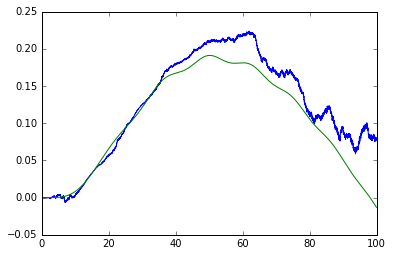

In [7]:
print (np.shape(np.mean(es,axis=1)))
p1 = np.load("../Examples/I1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps),np.mean(es,axis=1))
plot(ts,p1)



In [10]:
st="40"
e0 = np.load("200trajs_"+st+"ksteps0.npy")
e0a = np.zeros(np.shape(e0)[0])
for ii in range (30):
    e0 = np.load("200trajs_"+st+"ksteps"+str(ii)+".npy")
    e0a = np.mean(e0,axis=1) + e0a
e40 = np.array(e0a/(ii+1))


print np.shape(e40)

(40000,)


In [8]:
st="20"
e0 = np.load("200trajs_"+st+"ksteps0.npy")
e0a = np.zeros(np.shape(e0)[0])
for ii in range (20):
    e0 = np.load("200trajs_"+st+"ksteps"+str(ii)+".npy")
    e0a = np.mean(e0,axis=1) + e0a
e20 = np.array(e0a/(ii+1))


print np.shape(e20)

(20000,)


In [17]:
st="80"
e0 = np.load("200trajs_"+st+"ksteps0.npy")
e0a = np.zeros(np.shape(e0)[0])
for ii in range (5):
    e0 = np.load("200trajs_"+st+"ksteps"+str(ii)+".npy")
    e0a = np.mean(e0,axis=1) + e0a
e20 = np.array(e0a/(ii+1))


print np.shape(e80)

(80000,)


(80000, 200)


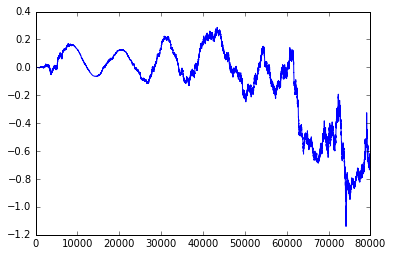

In [47]:
e0 = np.load("200trajs_"+st+"ksteps_w0.npy")
e0 = np.reshape(e0,[np.shape(e0)[0],np.shape(e0)[2]])
t = np.load("200trajs_"+st+"ksteps0.npy")

J = e0 + t
print np.shape(t)
#plot(J[:,2])
plot(t[:,2])

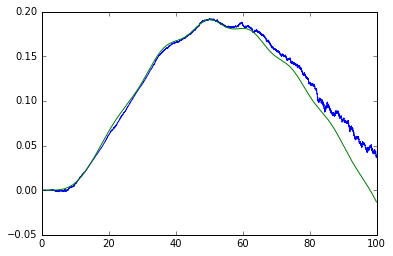

In [16]:
p1 = np.load("../Examples/I1.npy")
ts = np.load("../Examples/tlist.npy")
#plot(np.linspace(0,total_time, steps),2*e80[::2]-e40)
#plot(np.linspace(0,total_time, steps),e40[::2])
#plot(np.linspace(0,total_time, steps),e20)
plot(np.linspace(0,total_time, steps),e80[::4])
plot(ts,p1)



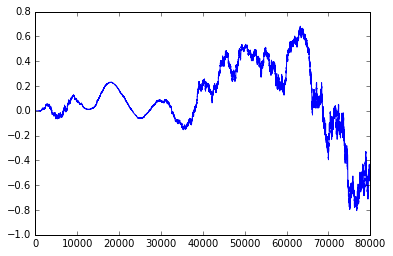

In [24]:
plot(e0[:,3])

In [56]:
t = time.time()
state = psi0[1]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1
psis = []
for ii in range (300):
    psis.append(initial_vector_c)
psis = np.transpose(psis)

for kk in range (5):
    Ws,ps = trajectories(psis)
#print initial_vector_c
    print (time.time()-t)

    ps = np.array(ps)

#(10,20001,50)
    ps2 = []
    for ii in range (np.shape(ps)[-1]):
        ps2.append(ps[:,:,ii])

    ps = ps2

    np.save("300trajs_80ksteps"+str(kk),ps)

#ps = np.reshape(ps,[np.shape(ps)[-1],np.shape(ps)[0],np.shape(ps)[1]])
#print kappa,gamma

179.955661058
457.060560942
638.369153023
808.705091
977.522602081


In [48]:
a = np.load("300trajs_40ksteps.npy")
b = np.load("300trajs_20ksteps.npy")
c = np.load("300trajs_80ksteps.npy")
print np.shape(a)
print np.shape(b)
print np.shape(c)

(300, 40001, 50)
(300, 20001, 50)
(300, 80001, 50)


In [49]:
print np.shape(a)
print np.shape(b)

print np.shape(2*a[:,::2,:]-b)

ps = 2*a[:,::2,:]-b
ps = c[:,::2,:]

ps2 = a

(300, 40001, 50)
(300, 20001, 50)
(300, 20001, 50)


In [8]:
t = time.time()
original = steps
steps = original*2
dt = total_time/float(steps)
u0 = []
signal = 0.1*np.tanh(np.linspace(0,total_time, steps)/10)
u0.append(signal)
Ws2,ps2 = trajectories(psis)
print (time.time()-t)
ps2 = np.array(ps2)

#(10,20001,50)
ps3 = []
for ii in range (np.shape(ps2)[-1]):
    ps3.append(ps2[:,:,ii])
ps2 = ps3

steps = original

181.50343895


In [10]:
print np.shape(ps)
print np.shape(ps2)

(1000, 20001, 50)


MemoryError: 

In [80]:
for ii in range (len(Js)):
    print round(Js[ii],3),round(Ws[ii],3),[round(ps[ii][jj],2) for jj in range (len(ps[ii]))]
    print "----------------------------------------------------"

0.0 0.0 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
----------------------------------------------------
0.0 0.162 [0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
----------------------------------------------------
0.0 -0.01 [-0.0, 1.0, 0.0, 0.0, -0.0, 0.0]
----------------------------------------------------
0.0 0.115 [0.0, 1.0, 0.0, 0.0, -0.0, 0.0]
----------------------------------------------------
0.0 0.078 [0.0, 1.0, 0.0, 0.0, -0.0, -0.0]
----------------------------------------------------
0.0 0.066 [0.0, 0.99, 0.0, 0.0, -0.0, -0.0]
----------------------------------------------------
0.0 -0.386 [-0.0, 0.99, 0.0, 0.0, -0.0, 0.0]
----------------------------------------------------
0.0 -0.199 [-0.0, 0.99, 0.0, 0.0, -0.0, -0.0]
----------------------------------------------------
0.0 -0.388 [-0.0, 0.99, 0.0, 0.0, -0.0, -0.0]
----------------------------------------------------
0.0 -0.055 [-0.0, 0.98, 0.0, 0.0, -0.0, -0.0]
----------------------------------------------------
0.001 0.053 [-0.0, 0.98, 0.0, 0.0, 

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: ComplexWarning: Casting complex values to real discards the imaginary part
  from ipykernel import kernelapp as app


In [53]:
state = psi0[1]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1
ps = []
ws = []
for ii in range(40):
    w,p = trajectory(initial_vector_c)
    ps.append(p)
    ws.append(w)
    if ii%10 ==0:
        print ii
#ps = ps/500
print "Done"
#plot(ps)

0
10
20
30
40
Done


In [149]:
print np.shape(ps)
print np.shape(ps[1])
ps = np.array(ps)
print ps[0,:,0]

#(10,20001,50)
ps2 = []
for ii in range (np.shape(ps)[-1]):
    ps2.append(ps[:,:,ii])

print np.shape(ps2)
print ps2[0][0]

ps = ps2

(20001, 50, 10)
(50, 10)
[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]
(10, 20001, 50)
[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j
  0.+0.j  0.+0.j  0.+0.j  0.+0.j  0.+0.j]


In [7]:
r = np.load("300trajs_80ksteps0.npy")

(300, 80001, 50)
300
0
1
2


/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


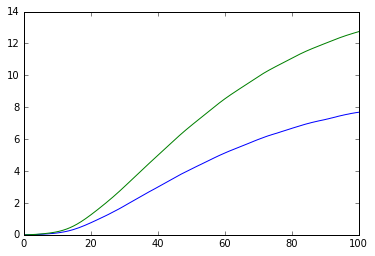

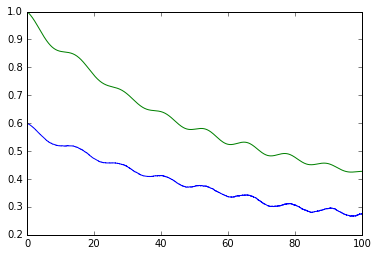

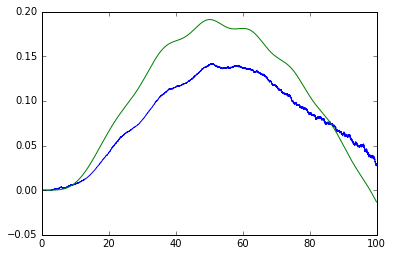

In [9]:
ps = r
original = steps
steps = np.shape(ps)[1]

print np.shape(ps)

print len(ps)

e=[]
expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
expect_op2 = np.dot(np.conjugate(np.transpose(c_ops[0])),c_ops[0])
expect_op3 = (np.conjugate(np.transpose(c_ops[1]))+c_ops[1])

J1 = np.array(np.zeros(steps))
J2 = np.array(np.zeros(steps))
J3 = np.array(np.zeros(steps))

for kk in range(3):
    print (kk)
    ps = np.load("300trajs_80ksteps"+str(kk)+".npy")
    for jj in range (len(ps)):

        inte = []
        inte2 = []
        inte3 = []
        for ii in range (steps):

            psm = ps[jj][ii]
            expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
            expect2 = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op2,psm))
            expect3 = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op3,psm))
            inte.append(expect)
            inte2.append(expect2)
            inte3.append(expect3)
        J1= J1+inte
        J2 = J2 +inte2
        J3 = J3 +inte3
J1 = J1/(3*len(ps))
J2 = J2/(3*len(ps))
J3 = J3/(3*len(ps))
#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/photons1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps),J1)
plot(ts,p1)

figure()


    
#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/qubit1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps),J2)
plot(ts,p1)

figure()


#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/I1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps),J3)
plot(ts,p1)
steps = original

(300, 80001, 50)
300


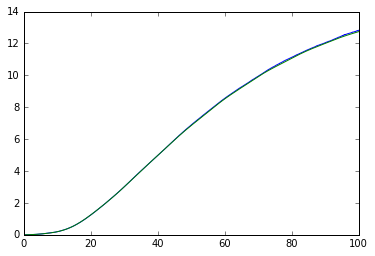

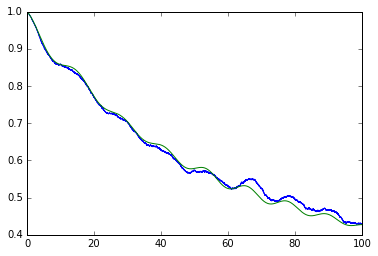

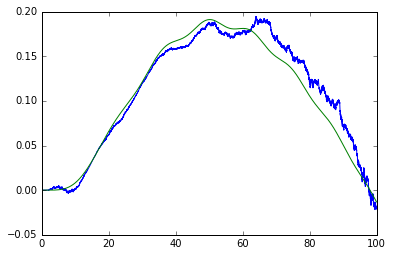

In [19]:
J11 = J1
J21 = J2
J31 = J3

#ps = ps2

original = steps
steps = np.shape(ps)[1]

print np.shape(ps)

print len(ps)

e=[]
expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
expect_op2 = np.dot(np.conjugate(np.transpose(c_ops[0])),c_ops[0])
expect_op3 = (np.conjugate(np.transpose(c_ops[1]))+c_ops[1])

J1 = np.array(np.zeros(steps))
J2 = np.array(np.zeros(steps))
J3 = np.array(np.zeros(steps))

for jj in range (len(ps)):
    
    inte = []
    inte2 = []
    inte3 = []
    for ii in range (steps):
        
        psm = ps[jj][ii]
        expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
        expect2 = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op2,psm))
        expect3 = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op3,psm))
        inte.append(expect)
        inte2.append(expect2)
        inte3.append(expect3)
    J1= J1+inte
    J2 = J2 +inte2
    J3 = J3 +inte3
J1 = J1/len(ps)
J2 = J2/len(ps)
J3 = J3/len(ps)
#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/photons1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps),J1)
plot(ts,p1)

figure()


    
#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/qubit1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps),J2)
plot(ts,p1)

figure()


#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/I1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps),J3)
plot(ts,p1)
steps = original

(40001,) (40000,)


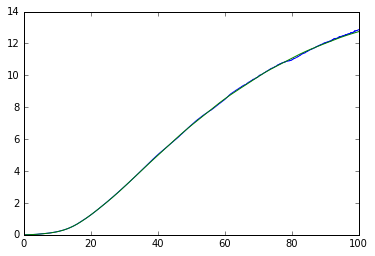

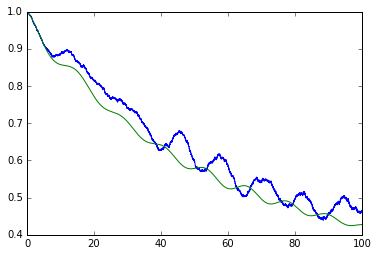

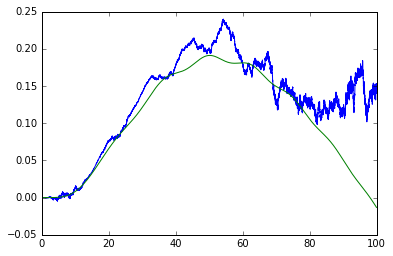

In [55]:
steps = original/2
print np.shape(2*J1-J11),np.shape(np.linspace(0,total_time, steps))
p1 = np.load("../Examples/photons1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps+1),2*J11-J1)
plot(ts,p1)

figure()


    
#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/qubit1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps+1),2*J21-J2)
plot(ts,p1)

figure()


#expect_op = np.dot(np.conjugate(np.transpose(c_ops[1])),c_ops[1])
        #cdag = np.conjugate(np.transpose(expect_op))
#expect = np.dot(np.conjugate(np.transpose(psm)),np.dot(expect_op,psm))
#plot(J)
p1 = np.load("../Examples/I1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps+1),2*J31-J3)
plot(ts,p1)
steps = original

0
100
200
300
400


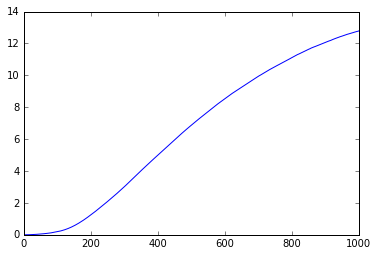

In [61]:
state = psi0[1]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1
J = np.array(np.zeros(steps+1))
for ii in range(500):
    J = J +np.array(trajectory(initial_vector_c)[0])
    if ii%100 ==0:
        print ii
J = J/500

plot(J)

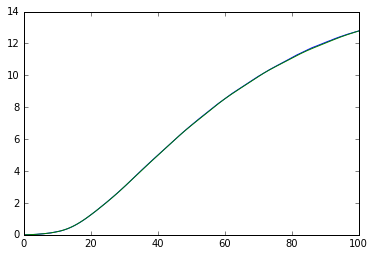

In [62]:
p1 = np.load("../Examples/photons1.npy")
ts = np.load("../Examples/tlist.npy")
plot(np.linspace(0,total_time, steps+1),J)
plot(ts,p1)

0
100
200
300
400


NameError: name 'ts' is not defined

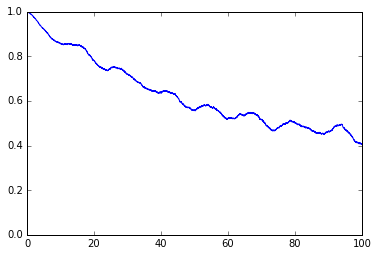

In [9]:
state = psi0[1]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1
#steps = 500
JJ = np.array(np.zeros(steps+1))
original = steps
for ii in range (500):
    steps = original
    u0 = []
    signal = 0.1*np.tanh(np.linspace(0,total_time, steps)/10)
    u0.append(signal)
    
    
    intermediate = np.array(np.zeros(steps+1))
    dt = total_time/float(steps)
    intermediate = np.array(trajectory(initial_vector_c)[0]) +intermediate
    
    steps = original*2
    dt = total_time/float(steps)
    u0 = []
    signal = 0.1*np.tanh(np.linspace(0,total_time, steps)/10)
    u0.append(signal)
    bb = np.array(trajectory(initial_vector_c)[0][::2])
    intermediate =  bb + bb - intermediate
    JJ = JJ + intermediate
    if ii%100 ==0:
        print ii
steps = original
plot (np.linspace(0,total_time, steps+1),JJ/500)
#plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))
plot(ts,p1)

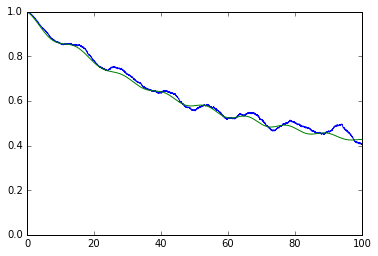

In [10]:
plot (np.linspace(0,total_time, steps+1),JJ/500)
p1 = np.load("../Examples/qubit1.npy")
ts = np.load("../Examples/tlist.npy")
plot(ts,p1)


In [118]:
state = psi0[1]
initial_vector_c=np.zeros(state_num)
initial_vector_c[state]=1
J = np.array(np.zeros(steps+1))
for ii in range(500):
    J = J +np.array(trajectory(initial_vector_c[0]))
    print ii
J = J/500

plot(J)

0
1
2
3
4
5
6
7
8
9


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide


KeyboardInterrupt: 

Verifying init vector id: 0
Verifying init vector id: 1
7604.48478893
Verifying init vector id: 0
Verifying init vector id: 1
2411.82922255
Verifying init vector id: 0
Verifying init vector id: 1
14181.1655411


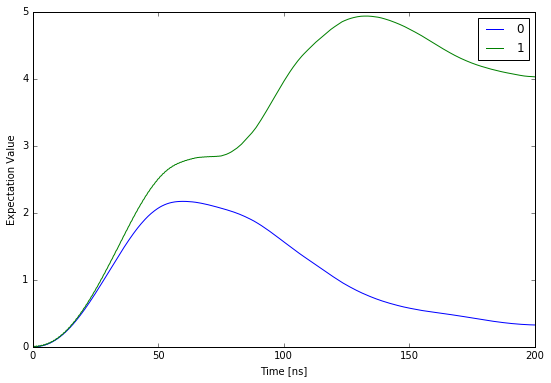

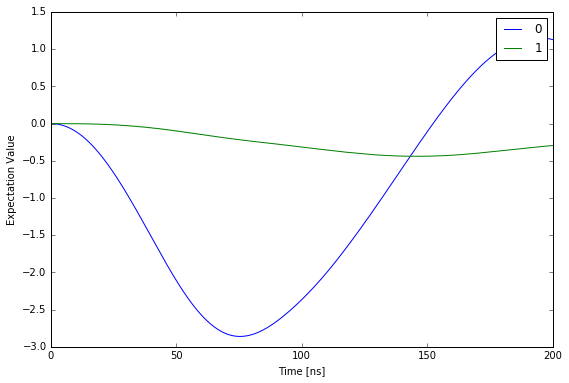

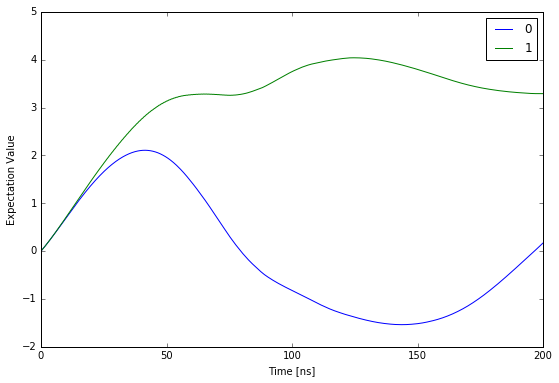

In [14]:
mmt_qutip_verification('/home/mohamed/Data/00164_JC.h5', np.dot(adag,a) )
mmt_qutip_verification('/home/mohamed/Data/00164_JC.h5', adag+a )
mmt_qutip_verification('/home/mohamed/Data/00164_JC.h5', (0+1j)* (a-adag) )

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
0.05
1001
501


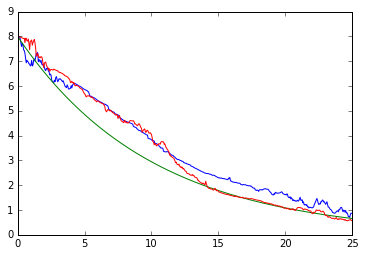

In [94]:
#damped harmonic Euler
state_num = 12
initial_vector_c=np.zeros(state_num)
initial_vector_c[8]=1

print initial_vector_c

total_time = 25
steps = 500
gamma = 0.1
dt = float(total_time)/steps

print dt

a =np.diag(np.sqrt(np.arange(1,state_num)),1)

def trajectory(psi):
    def get_D1cop(cop,psi,rate):
        cdag = np.conjugate(np.transpose(cop))
        expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(cop + cdag,psi))
        op = expect * cop - np.dot(cdag,cop) - 0.25*expect*expect
        op = op*rate*0.5
        return op

    

    def get_D2(cop,psi,rate):
        cdag = np.conjugate(np.transpose(cop))
        expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(cop + cdag,psi))
        op = cop - 0.5 *expect
        op = op*np.sqrt(rate)
        return op

    def normalize(psi):
        norm = np.dot(np.conjugate(np.transpose(psi)),psi)
        return psi/np.sqrt(norm)

    J = []
    
    expect_op = np.dot(np.conjugate(np.transpose(a)),a)
    #cdag = np.conjugate(np.transpose(expect_op))
    expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(expect_op,psi))
    J.append(expect)
    #print expect
    for step in range(steps):

        
        D1 = get_D1cop(a,psi,gamma) 
        D1psi = np.dot(D1,psi)
        D21 = get_D2(a,psi,gamma)
        
        D21psi = np.dot(D21,psi)
        
        dW1 = np.random.normal() * np.sqrt(dt)
        
        newpsi = psi + D1psi *dt + D21psi *dW1 
        #newpsi = newpsi + 0.5*(dW1*dW1 - dt)*np.dot(np.dot(D21,D21),psi) +  0.5*(dW2*dW2 - dt)*np.dot(np.dot(D22,D22),psi) 
        
        #dWe1 = np.random.normal() * np.sqrt(dt*0.5)
        #extrapsi = normalize(psi + D1psi *dt*0.5 + D21psi *dWe1)
        #D1e = get_D1cop(a,extrapsi,gamma) 
        #D1psie = np.dot(D1e,extrapsi)
        #D21e = get_D2(a,extrapsi,gamma)
        
        #D21psie = np.dot(D21e,extrapsi)
        
        #dWe2 = np.random.normal() * np.sqrt(dt*0.5)
        #extrapsi = extrapsi + D1psie *dt*0.5 + D21psi *dWe2
        
        #newpsi = 2*extrapsi - newpsi
        psi = normalize(newpsi)
        #print np.dot(np.conjugate(np.transpose(psi)),psi)
        
        #print expect
        expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(expect_op,psi))
        J.append(expect)

    #plot(J)
    return J

JJ = trajectory(initial_vector_c)
plot (np.linspace(0,total_time, steps+1),JJ)
plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))
#print JJ

total_time = 25
steps = 1000
dt = total_time/float(steps)
JJ2 = trajectory(initial_vector_c)
plot (np.linspace(0,total_time,steps/2 +1),JJ2[::2])
#plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))
print len(JJ2)
print len(JJ2[::2])

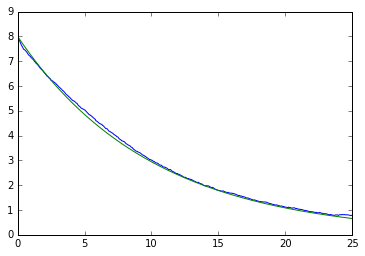

In [105]:
steps = 500
JJ = np.array(np.zeros(steps+1))

for ii in range (1000):
    
    total_time = 25
    steps = 500
    intermediate = np.array(np.zeros(steps+1))
    dt = total_time/float(steps)
    intermediate = np.array(trajectory(initial_vector_c)) +intermediate
    total_time = 25
    steps = 1000
    dt = total_time/float(steps)
    bb = np.array(trajectory(initial_vector_c)[::2])
    intermediate =  bb + bb - intermediate
    JJ = JJ + intermediate
steps = 500
plot (np.linspace(0,total_time, steps+1),JJ/1000)
plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))

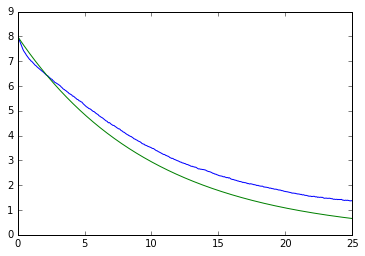

In [106]:
steps = 500
JJ = np.array(np.zeros(steps+1))

for ii in range (1000):
    
    total_time = 25
    steps = 500
    intermediate = np.array(np.zeros(steps+1))
    dt = total_time/float(steps)
    
    JJ = JJ + np.array(trajectory(initial_vector_c))
steps = 500
plot (np.linspace(0,total_time, steps+1),JJ/1000)
plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))

[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
0.05


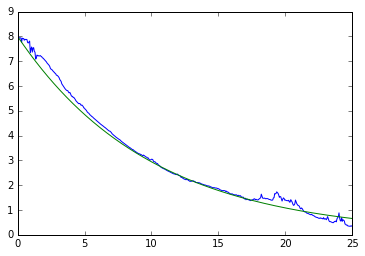

In [114]:
#damped harmonic 2nd order
state_num = 12
initial_vector_c=np.zeros(state_num)
initial_vector_c[8]=1

print initial_vector_c

total_time = 25
steps = 500
gamma = 0.1
dt = float(total_time)/steps

print dt

a =np.diag(np.sqrt(np.arange(1,state_num)),1)

def trajectory(psi):
    def get_D1cop(cop,psi,rate):
        cdag = np.conjugate(np.transpose(cop))
        expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(cop + cdag,psi))
        op = expect * cop - np.dot(cdag,cop) - 0.25*expect*expect
        op = op*rate*0.5
        return op

    

    def get_D2(cop,psi,rate):
        cdag = np.conjugate(np.transpose(cop))
        expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(cop + cdag,psi))
        op = cop - 0.5 *expect
        op = op*np.sqrt(rate)
        return op

    def normalize(psi):
        norm = np.dot(np.conjugate(np.transpose(psi)),psi)
        return psi/np.sqrt(norm)

    J = []
    
    expect_op = np.dot(np.conjugate(np.transpose(a)),a)
    #cdag = np.conjugate(np.transpose(expect_op))
    expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(expect_op,psi))
    J.append(expect)
    #print expect
    for step in range(steps):

         
        D1 = get_D1cop(a,psi,gamma) 
        D1psi = np.dot(D1,psi)
        D21 = get_D2(a,psi,gamma)
        
        D21psi = np.dot(D21,psi)
        
        dW1 = np.random.normal() * np.sqrt(dt)
        
        psibar = psi + D1psi *dt + D21psi *dW1 
        psiplus = psi + D1psi *dt + D21psi *np.sqrt(dt)
        psiminus = psi + D1psi *dt - D21psi *np.sqrt(dt)
        D1psibar = np.dot(get_D1cop(a,psibar,gamma),psibar)
        D2psiplus = np.dot(get_D2(a,psiplus,gamma),psiplus)
        D2psiminus = np.dot(get_D2(a,psiminus,gamma),psiminus)
        
        
        
        newpsi = psi + 0.5*dt*(D1psi+D1psibar)
        newpsi = newpsi + 0.25*dW1*(D2psiplus+D2psiminus+2*D21psi)
        newpsi = newpsi + 0.25* (1/np.sqrt(dt))*(dW1*dW1-dt)*(D2psiplus-D2psiminus)
        #newpsi = newpsi + 0.5*(dW1*dW1 - dt)*np.dot(np.dot(D21,D21),psi) +  0.5*(dW2*dW2 - dt)*np.dot(np.dot(D22,D22),psi) 
        
        
        psi = normalize(newpsi)
        #print np.dot(np.conjugate(np.transpose(psi)),psi)
        
        #print expect
        expect = np.dot(np.conjugate(np.transpose(psi)),np.dot(expect_op,psi))
        J.append(expect)

    #plot(J)
    return J

JJ = trajectory(initial_vector_c)
plot (np.linspace(0,total_time, steps+1),JJ)
plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))
#print JJ

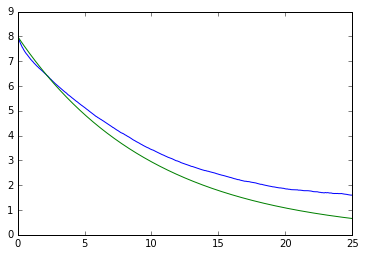

In [115]:
JJ = np.zeros(steps+1)
for ii in range (1000):
    JJ = trajectory(initial_vector_c) +JJ

plot (np.linspace(0,total_time, steps+1),JJ/1000)
plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))

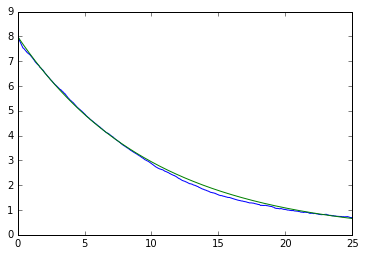

In [116]:
steps = 500
JJ = np.array(np.zeros(steps+1))

for ii in range (1000):
    
    total_time = 25
    steps = 500
    intermediate = np.array(np.zeros(steps+1))
    dt = total_time/float(steps)
    intermediate = np.array(trajectory(initial_vector_c)) +intermediate
    total_time = 25
    steps = 1000
    dt = total_time/float(steps)
    bb = np.array(trajectory(initial_vector_c)[::2])
    intermediate =  bb + bb - intermediate
    JJ = JJ + intermediate
steps = 500
plot (np.linspace(0,total_time, steps+1),JJ/1000)
plot (np.linspace(0,total_time, steps),8*exp(-gamma*np.linspace(0,total_time, steps)))